In [23]:
# import packages
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns  


In [24]:
# Import data
home_dir = Path.home()
work_dir = (home_dir / 'Desktop' / 'GitHub' / 'election_inflation_analysis')
data = (work_dir / 'data')
raw_data = (data / 'raw')
clean_data = (data / 'clean')
code = Path.cwd()
output = work_dir / 'output'

zillow_rent = raw_data / 'zillow_median_rent_raw.csv'
df_zillow = pd.read_csv(zillow_rent)

election_file = clean_data / 'trump_2020_2024.csv'
df_election = pd.read_csv(election_file)

crosswalk_file = clean_data / 'msa_county_crosswalk.csv'
crosswalk = pd.read_csv(crosswalk_file)

# drop election duplicates
df_election = df_election.drop_duplicates()

In [25]:
# Prepare for merge
df_election['county'] = df_election['county_name'] + ", " + df_election['state']

df_election = df_election.dropna(subset=['2020-2024 swing'])

# Merge in MSA and County Crosswalk
election_county_msa = pd.merge(df_election, crosswalk, on='county', how='outer')

# Get vote swing for MSA levels
election_msa = election_county_msa.groupby('msa_short', as_index = False).sum()
election_msa['trump_share_2020'] = election_msa['trump votecount, 2020'] / election_msa['totalvotes, 2020']
election_msa['trump_share_2024'] = election_msa['trump votecount, 2024'] / election_msa['totalvotes, 2024']
election_msa['vote_swing'] = (election_msa['trump_share_2024'] - election_msa['trump_share_2020']) * 100

election_msa['regionname'] = election_msa['msa_short'].str.lower()
keep = ['regionname', 'vote_swing', 'msa_short']
election_msa = election_msa[keep]

# save
file = output / "vote_swing.csv"
election_msa.to_csv(file, index=False)

# Merge with Zillow Data

In [26]:
# Prepare Zillow for merge
df_zillow.columns = df_zillow.columns.str.lower()
df_zillow['regionname'] = df_zillow['regionname'].str.lower()
df_zillow['inflation'] = (df_zillow['10/31/2024'] - df_zillow['12/31/2020'])/df_zillow['12/31/2020']*100

keep = ['regionname', 'inflation']
zillow_inflation = df_zillow[keep]

# Merge
zillow_election = pd.merge(zillow_inflation, election_msa, on='regionname', how = 'outer')
file = output / "zillow_vote_swing.csv"
zillow_election.to_csv(file, index=False)

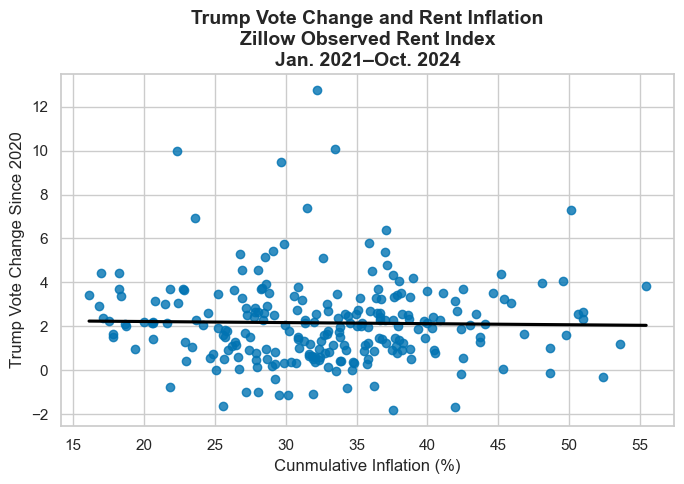

In [27]:
# Graph
sns.set_theme(style="whitegrid", palette="colorblind")

plt.figure(figsize=(7, 5))
sns.regplot(data=zillow_election, x="inflation", y="vote_swing", scatter=True, ci=None, line_kws={"color": "black"})

# Customize the plot
plt.title("Trump Vote Change and Rent Inflation\nZillow Observed Rent Index\nJan. 2021–Oct. 2024", fontsize=14, fontweight="bold")
plt.xlabel("Cunmulative Inflation (%)", fontsize=12)
plt.ylabel("Trump Vote Change Since 2020", fontsize=12)
plt.tight_layout()

output_graph = output / 'zillow_election.png'
plt.savefig(output_graph, dpi=900, bbox_inches='tight')
plt.show()



# Examine Zillow data

In [28]:
# # Calculate the total number of rows in the dataset
# total_rows = len(df_zillow)

# # Calculate the percentage of rows with missing values for the filtered columns
# filtered_missing_values_percentage = (df_zillow[filtered_date_columns].isnull().sum() / total_rows) * 100

# # Create a histogram for the percentage of missing values
# plt.figure(figsize=(12, 6))
# plt.bar(filtered_date_columns, filtered_missing_values_percentage, width=0.8)
# plt.xlabel('Date', fontsize=12)
# plt.ylabel('Percentage of Rows with Missing Values (%)', fontsize=12)
# plt.title('Percentage of Missing Values by Date (After 12/31/2020)', fontsize=14)
# plt.xticks(rotation=90, fontsize=8)
# plt.tight_layout()
# plt.show()


In [29]:
# # Describe inflation
# inflation_zillow = zillow_election['inflation'].describe()
# print(inflation_zillow)